<a href="https://colab.research.google.com/github/Minhvt34/RUL_Transformer/blob/main/MiniTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 13.3 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import random
random.seed(42)

In [4]:
train_data_path = "/content/data/b1_2_hor_data_raw.npy"
with open(train_data_path, "rb") as f:
  train_b1_2 = np.load(f, allow_pickle=True)
print(train_b1_2.shape)

train_b1_2 = train_b1_2.reshape(-1, 256).astype(float)

time_2 = np.linspace(0.001, 145.870000, train_b1_2.shape[0]*16)
time_2 = time_2.reshape(-1, 16)

train_b1_2 = np.concatenate((train_b1_2, time_2), axis = 1)
train_b1_2.shape

# Column information
NUMERIC_FEATURES = [f'f{i}' for i in range(256)]
#CATEGORICAL_FEATURES = ['state']
TIME_FEATURES = [f't{i}' for i in range(16)]


FEATURES = list(NUMERIC_FEATURES) + list(TIME_FEATURES)
LABEL = 'rul'

(2229760,)


In [5]:
train_data = pd.DataFrame(data=train_b1_2, columns=FEATURES)
train_data.shape

(8710, 272)

In [6]:
train_data[LABEL] = np.array(list(np.linspace(1.00, 0.001, train_b1_2.shape[0])))
train_data[LABEL].mean()

0.5005000000000001

In [7]:
train_data[FEATURES] = train_data[FEATURES].astype(float)
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])

batch_size = 256
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL, batch_size=batch_size)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, batch_size=batch_size, shuffle=False)  # No shuffle

/content/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/content/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [8]:
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss):
    # initialize instance attributes
    def __init__(self, threshold=1):
        super(MyHuberLoss, self).__init__()
        self.threshold = threshold

    # Compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - self.threshold / 2)
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [9]:
from tabtransformertf.models.fttransformer import Time2Vec
t2v_encoder = Time2Vec(
    time_features=TIME_FEATURES,
    kernel_size=16,
    t2v_emb_dim=16
)

In [10]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = [],
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = None,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=128,
    depth=4,
    heads=8,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

# Pass th encoder to the model
ft_linear_model = FTTransformer(
    encoder=ft_linear_encoder,
    t2v_encoder=t2v_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 5e-4
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 2

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_model.compile(
    optimizer = optimizer,
    loss = {"output": MyHuberLoss(threshold=0.05), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]
ft_linear_history = ft_linear_model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/2
*****************time input shape: (None, 16, 1)
*****************time input shape: (None, 16, 1)
*****************time input shape: (None, 16, 1)
28/28 [==============================] - 23s 410ms/step - loss: 0.0126 - output_loss: 0.0126 - output_rmse: 0.3688 - val_loss: 0.0076 - val_output_loss: 0.0076 - val_output_rmse: 0.2363
Epoch 2/2
28/28 [==============================] - 11s 371ms/step - loss: 0.0039 - output_loss: 0.0039 - output_rmse: 0.1530 - val_loss: 4.4526e-04 - val_output_loss: 4.4526e-04 - val_output_rmse: 0.0302


In [11]:
ft_linear_model.summary()

Model: "ft_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ft_transformer_encoder (FTT  multiple                 2277248   
 ransformerEncoder)                                              
                                                                 
 layer_normalization_8 (Laye  multiple                 256       
 rNormalization)                                                 
                                                                 
 dense_8 (Dense)             multiple                  2064      
                                                                 
 dense_9 (Dense)             multiple                  289       
                                                                 
 Time2VecLayer_SIN (Time2Vec  multiple                 34        
 )                                                               
                                                    

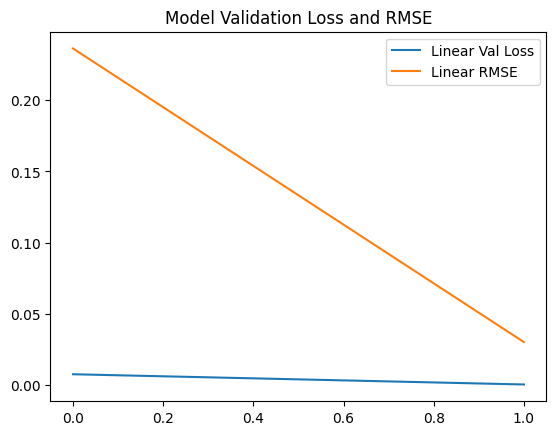

In [12]:
plt.plot(ft_linear_history.history['val_loss'], label='Linear Val Loss')
plt.plot(ft_linear_history.history['val_output_rmse'], label='Linear RMSE')

plt.title('Model Validation Loss and RMSE')
plt.legend()
plt.show()

In [13]:
linear_val_preds = ft_linear_model.predict(val_dataset)

*****************time input shape: (None, 16, 1)
7/7 [==============================] - 2s 124ms/step


In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
RMSE = np.sqrt(mean_squared_error(X_val[LABEL].values, linear_val_preds['output'].ravel()))
RMSE

0.030208034195433952